# Library Import

In [1]:
# 데이터 분석에 사용할 라이브러리
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# error 창 안 보이게 해줌
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# 가용폰트 확인
for font in mpl.font_manager.findSystemFonts():
    # print(mpl.font_manager.FontProperties(fname=font).get_name())
    mpl.font_manager.fontManager.addfont(font)

# Set font family globally
mpl.rcParams['font.family'] = 'NanumBarunGothic'# 폰트명
print(mpl.rcParams['font.family'])

['NanumBarunGothic']


# Global Variables

In [2]:
import easydict
args = easydict.EasyDict()

In [3]:
default_path = 'C:/titanic_datas/'
train_csv = default_path + 'train.csv'
test_csv = default_path + 'test.csv'
default_submission_csv = default_path + 'submission.csv'

submission_csv = default_path + 'result/solution.csv'
save_results = default_path + 'result/model_results.json'

random_state = 21
results = []

In [4]:
DATA_PATH = 'C:/titanic_datas/'

df = pd.read_csv(DATA_PATH+'train.csv')
df.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [5]:
ori_tr = pd.read_csv(train_csv)
ori_te = pd.read_csv(test_csv)

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [6]:
pd.read_csv(default_submission_csv).shape

(393, 2)

In [7]:
ori_tr.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

# train test split

In [8]:
new_survived = pd.Categorical(ori_tr["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])              

new_survived.describe()

,counts,freqs
categories,,
Died,570,0.622271
Survived,346,0.377729


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
y = ori_tr['survived']
X = ori_tr

In [11]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, stratify=ori_tr['survived'], random_state=random_state
)

In [12]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((641, 12), (275, 12), (641,), (275,))

In [13]:
train = X_tr.copy()
test = X_te.copy()
ori_te = ori_te.copy()

# Data Cleaning

In [14]:
ori_te.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age             83
sibsp            0
parch            0
ticket           0
fare             1
cabin          296
embarked         1
dtype: int64

In [15]:
print('train:', X_tr.isnull().sum().sum())
print('test:', X_te.isnull().sum().sum())
print('ori_te:', ori_te.isnull().sum().sum())

train: 635
test: 264
ori_te: 381


In [16]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def get_cols_cleaning(p_pd_list:list) -> list:
  cols_cleaning = []
  for df in p_pd_list:
    # 결측치 컬럼 조회
    tmp = df.isnull().sum()
    cols_cleaning += list(tmp[df.isnull().sum() > 0].index)

  cols_cleaning = list(set(cols_cleaning))
  print(f'cols_cleaning: {cols_cleaning}')
  return cols_cleaning

def add_cols_cleaning(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  pd_list = [p_train, p_test, p_ori_te]
  for col in get_cols_cleaning(pd_list):  
    for i, df in enumerate(pd_list, start=1):
      
      if is_numeric_dtype(df[col]): # 숫자형 결측치 처리
        new_col = col+'_cleaning'
        df[new_col] = df[col]   
        # random sampling
        random_sampling = (p_train[col].dropna().sample(df[col].isnull().sum()))
        # index 부여
        random_sampling.index = df[lambda x: x[col].isnull()].index 
        # NA imputation
        df.loc[df[col].isnull(), new_col] = random_sampling
        
        # 기존 결측치 컬럼 제거
        if i == len(pd_list):
          for _df in pd_list:
            _df.drop([col], axis=1, inplace=True)
      
      else: # 범주형 결측치 처리
        df[col].fillna(p_train[col].mode().values[0], inplace=True)

  print(f'p_train: {p_train.isnull().sum().sum()} / p_test: {p_test.isnull().sum().sum()} / p_ori_te: {p_ori_te.isnull().sum().sum()}')

In [17]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [18]:
add_cols_cleaning(X_tr, X_te, ori_te)

cols_cleaning: ['embarked', 'age', 'cabin', 'fare']
p_train: 0 / p_test: 0 / p_ori_te: 0


In [19]:
print('train:', X_tr.isnull().sum().sum())
print('test:', X_te.isnull().sum().sum())
print('ori_te:', ori_te.isnull().sum().sum())

train: 0
test: 0
ori_te: 0


# Feature Extraction with EDA

- features
- 귀족들이 많다. -> name에서 추출
- cabin -> 세월호 때 호실 찾는 거, 기록이 안 된 사람들은 사망했을 가능성이 높다.
- age -> 결측치 넣기 전 분포로 확인함, 결측치를 무엇으로 채울 지 결정

name

In [20]:
dict_designation = {
    'Mr.': '남성',
    'Master.': '남성',
    'Sir.': '남성',
    'Miss.': '미혼 여성',
    'Mrs.': '기혼 여성',
    'Ms.': '미혼/기혼 여성',
    'Lady.': '숙녀',
    'Mlle.': '아가씨',
    # 직업
    'Dr.': '의사',
    'Rev.': '목사',
    'Major.': '계급',
    'Don.': '교수',
    'Col.': '군인',
    'Capt.': '군인',
    # 귀족
    'Mme.': '영부인',
    'Countess.': '백작부인',
    'Jonkheer.': '귀족'
}

def add_designation(name): # 호칭 함수
  designation = "unknown"
  for key in dict_designation.keys():
    if key in name:
      designation = key
      break
  return designation

train['designation'] = train['name'].map(lambda x: add_designation(x))
test['designation'] = test['name'].map(lambda x: add_designation(x))

train.designation.value_counts()

Mr.          370
Miss.        126
Mrs.         106
Master.       22
Rev.           4
Dr.            3
Col.           3
Major.         2
Capt.          1
Mlle.          1
Ms.            1
Sir.           1
Jonkheer.      1
Name: designation, dtype: int64

In [21]:
pd.crosstab(train.designation,train.gender).T.style.background_gradient(cmap='summer_r') 
#Checking the Initials with the Gender

designation,Capt.,Col.,Dr.,Jonkheer.,Major.,Master.,Miss.,Mlle.,Mr.,Mrs.,Ms.,Rev.,Sir.
gender,,,,,,,,,,,,,
female,0,0,0,0,0,0,126,1,0,106,1,0,0
male,1,3,3,1,2,22,0,0,370,0,0,4,1


In [22]:
train.cabin.isnull().sum()

506

age

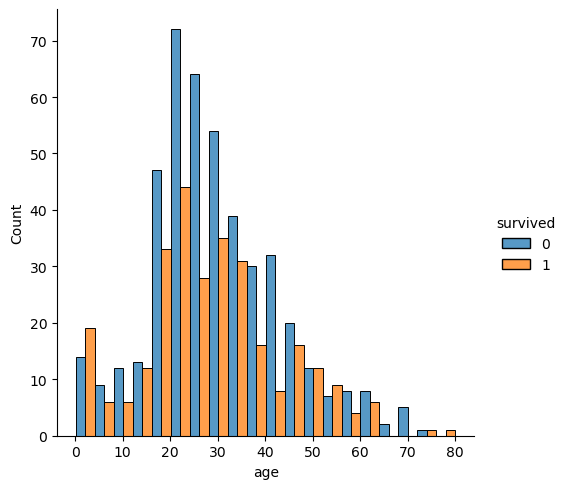

In [23]:
sns.displot(ori_tr, x='age', hue="survived", multiple="dodge", bins=20)
plt.show()

In [24]:
c1 = ori_tr['age'] <= 5
ori_tr.loc[c1]['survived'].mean()

0.5833333333333334

In [25]:
c1 = ori_tr['age'] <= 10
c2 = ori_tr['age'] > 5
c = c1 & c2
ori_tr.loc[c]['survived'].mean()

0.2916666666666667

In [26]:
c1 = ori_tr['age'] > 5
ori_tr.loc[c1]['survived'].mean()

0.38

In [27]:
age_median = train['age'].median()
fare_median = train['fare'].median()
embarked_mode = train['embarked'].mode().values[0]

In [28]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'sibsp', 'parch', 'ticket',
       'cabin', 'embarked', 'age_cleaning', 'fare_cleaning'],
      dtype='object')

In [29]:
train['age'].fillna(age_median, inplace=True)
test['age'].fillna(age_median, inplace=True)
ori_te['age_cleaning'].fillna(age_median, inplace=True)

train['fare'].fillna(fare_median, inplace=True)
test['fare'].fillna(fare_median, inplace=True)
ori_te['fare_cleaning'].fillna(fare_median, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(506, 212, 0)

add infant

In [30]:
def add_infant(age):
  result = 0
  try:
    if age <= 5:
      result = 1
  except:
    pass
  return result

train['infant'] = train['age'].map(lambda x: add_infant(x))
test['infant'] = test['age'].map(lambda x: add_infant(x))
ori_te['infant'] = ori_te['age_cleaning'].map(lambda x: add_infant(x))

print(f"{train['infant'].nunique()} / \n {train['infant'].unique()} \n")
train.shape, test.shape, ori_te.shape

2 / 
 [0 1] 



((641, 14), (275, 14), (393, 12))

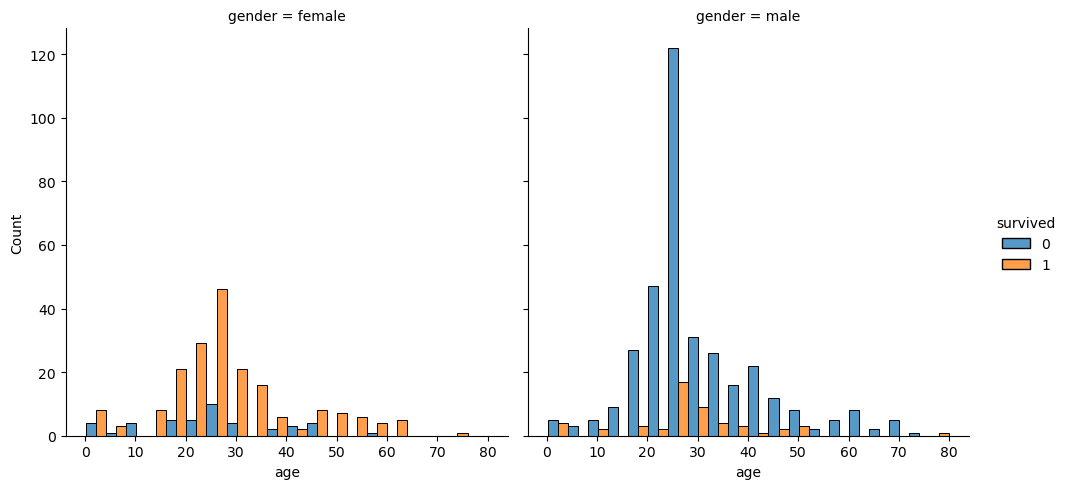

In [31]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")
plt.show()

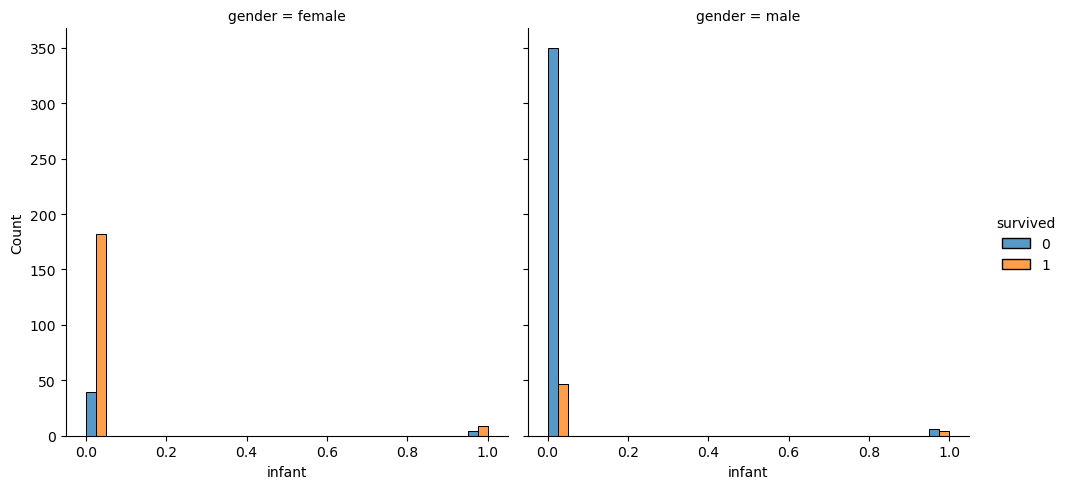

In [32]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")
plt.show()

add gender_infant

In [33]:
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"{train['gender_infant'].nunique()} / \n {train['gender_infant'].unique()} \n")
train.shape, test.shape, ori_te.shape

4 / 
 ['female_0' 'male_0' 'female_1' 'male_1'] 



((641, 15), (275, 15), (393, 13))

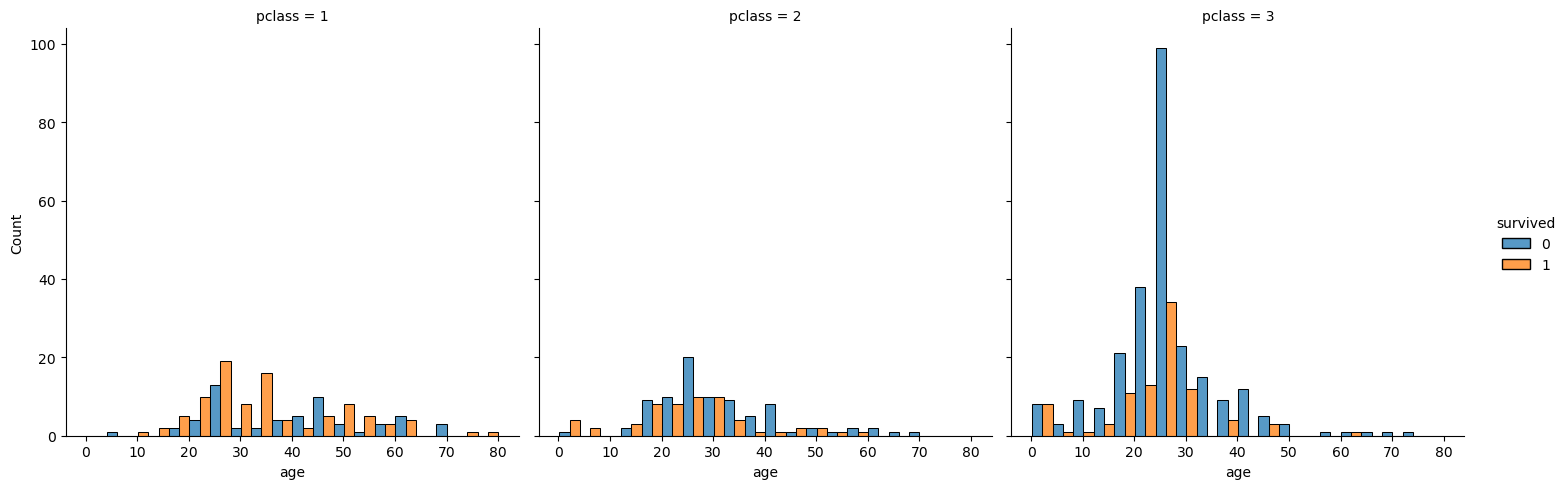

In [34]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass")
plt.show()

In [35]:
from sklearn.tree import DecisionTreeClassifier

# Encoding

In [36]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
train = train.drop(['name', 'ticket', 'cabin', 'survived'], axis=1)
test = test.drop(['name', 'ticket', 'cabin', 'survived'], axis=1)

In [38]:
train.columns

Index(['passengerid', 'pclass', 'gender', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'designation', 'infant', 'gender_infant'],
      dtype='object')

In [39]:
test.columns

Index(['passengerid', 'pclass', 'gender', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'designation', 'infant', 'gender_infant'],
      dtype='object')

In [40]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'sibsp', 'parch', 'ticket',
       'cabin', 'embarked', 'age_cleaning', 'fare_cleaning', 'infant',
       'gender_infant'],
      dtype='object')

In [41]:
train = train.drop(['designation'], axis=1)
test = test.drop(['designation'], axis=1)

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 812 to 277
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    641 non-null    int64  
 1   pclass         641 non-null    int64  
 2   gender         641 non-null    object 
 3   age            641 non-null    float64
 4   sibsp          641 non-null    int64  
 5   parch          641 non-null    int64  
 6   fare           641 non-null    float64
 7   embarked       641 non-null    object 
 8   infant         641 non-null    int64  
 9   gender_infant  641 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 71.2+ KB


In [43]:
enc_cols = list(train.select_dtypes(exclude=np.number).columns)
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder() 
enc_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(), 
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = enc_dfs[0]
test = enc_dfs[1]
ori_te = enc_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

len_enc_cols: 3
0 / 0 / 0


((641, 16), (275, 16), (393, 19))

In [44]:
train.shape, y_tr.shape, ori_te.shape

((641, 16), (641,), (393, 19))

In [45]:
train.columns

Index(['pclass', 'fare', 'age', 'passengerid', 'parch', 'sibsp', 'infant',
       'gender_female', 'gender_male', 'embarked_C', 'embarked_Q',
       'embarked_S', 'gender_infant_female_0', 'gender_infant_female_1',
       'gender_infant_male_0', 'gender_infant_male_1'],
      dtype='object')

In [46]:
test.columns

Index(['pclass', 'fare', 'age', 'passengerid', 'parch', 'sibsp', 'infant',
       'gender_female', 'gender_male', 'embarked_C', 'embarked_Q',
       'embarked_S', 'gender_infant_female_0', 'gender_infant_female_1',
       'gender_infant_male_0', 'gender_infant_male_1'],
      dtype='object')

In [47]:
ori_te.columns

Index(['pclass', 'age_cleaning', 'name', 'fare_cleaning', 'passengerid',
       'sibsp', 'parch', 'infant', 'cabin', 'ticket', 'gender_female',
       'gender_male', 'embarked_C', 'embarked_Q', 'embarked_S',
       'gender_infant_female_0', 'gender_infant_female_1',
       'gender_infant_male_0', 'gender_infant_male_1'],
      dtype='object')

In [48]:
train = train.drop(['passengerid'], axis=1)
test = test.drop(['passengerid'], axis=1)
ori_te = ori_te.drop(['name', 'ticket', 'cabin'], axis=1)

In [49]:
modelV4 = DecisionTreeClassifier(random_state=random_state)

modelV4.fit(train, y_tr)

DecisionTreeClassifier(random_state=21)

In [50]:
score_tr = modelV4.score(train, y_tr)
score_te = modelV4.score(test, y_te) 

score_tr, score_te 

(0.982839313572543, 0.7709090909090909)

In [51]:
from sklearn.metrics import roc_curve, auc 

y_pred = modelV4.predict_proba(test)[:,1]  # proba: 확률 예측
fpr, tpr, thresholds = roc_curve(y_te,y_pred)

auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.7514619883040936


In [52]:
modelV4.feature_importances_

array([0.05932543, 0.19651105, 0.16740692, 0.00971285, 0.04414459,
       0.        , 0.        , 0.49297873, 0.00766071, 0.00136779,
       0.02089193, 0.        , 0.        , 0.        , 0.        ])

In [53]:
df_feature_importances = pd.DataFrame(modelV4.feature_importances_, train.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(15, 2)


,index,0
0,gender_male,0.492979
1,fare,0.196511
2,age,0.167407
3,pclass,0.059325
4,sibsp,0.044145
5,embarked_S,0.020892
6,parch,0.009713
7,embarked_C,0.007661
8,embarked_Q,0.001368
9,infant,0.000000


In [54]:
train.shape, test.shape, ori_te.shape

((641, 15), (275, 15), (393, 16))

In [55]:
train.columns

Index(['pclass', 'fare', 'age', 'parch', 'sibsp', 'infant', 'gender_female',
       'gender_male', 'embarked_C', 'embarked_Q', 'embarked_S',
       'gender_infant_female_0', 'gender_infant_female_1',
       'gender_infant_male_0', 'gender_infant_male_1'],
      dtype='object')

In [56]:
ori_te.columns

Index(['pclass', 'age_cleaning', 'fare_cleaning', 'passengerid', 'sibsp',
       'parch', 'infant', 'gender_female', 'gender_male', 'embarked_C',
       'embarked_Q', 'embarked_S', 'gender_infant_female_0',
       'gender_infant_female_1', 'gender_infant_male_0',
       'gender_infant_male_1'],
      dtype='object')

In [57]:
# Model1 (initial별 최빈값을 age에 대입) randomforest

#set ids as PassengerId and predict survival 
ids = ori_te['passengerid']
predictions = modelV4.predict(ori_te.drop('passengerid' , axis=1))

#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'passengerid' : ids, 'survived': predictions })
output.to_csv('C:/titanic_datas/result/Test.csv', index=False)

c:\Users\Playdata\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- age_cleaning
- fare_cleaning
Feature names seen at fit time, yet now missing:
- age
- fare

  warnings.warn(message, FutureWarning)
